In [1]:
import gc
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from _code.card_selection import card_sampler, \
            plot_card_trends, card_imager, \
                synthesize_names

from IPython.display import Image

Need to create a translator from price data to real data
using a different all cards set. Main db is scryfall but
pricing data comes from mtgjson.com

In [2]:
trans_df = pd.read_json('./data/AllPrintings.json')

In [3]:
trans_df.drop(columns='meta',inplace=True)
trans_df.dropna(inplace=True)
display(
    trans_df.head(),
    trans_df.info
    )

,data
10E,"{'baseSetSize': 383, 'block': 'Core Set', 'boo..."
2ED,"{'baseSetSize': 302, 'block': 'Core Set', 'boo..."
2X2,"{'baseSetSize': 577, 'booster': {'collector': ..."
2XM,"{'baseSetSize': 332, 'booster': {'default': {'..."
30A,"{'baseSetSize': 594, 'booster': {'default': {'..."


<bound method DataFrame.info of                                                    data
10E   {'baseSetSize': 383, 'block': 'Core Set', 'boo...
2ED   {'baseSetSize': 302, 'block': 'Core Set', 'boo...
2X2   {'baseSetSize': 577, 'booster': {'collector': ...
2XM   {'baseSetSize': 332, 'booster': {'default': {'...
30A   {'baseSetSize': 594, 'booster': {'default': {'...
...                                                 ...
YSNC  {'baseSetSize': 30, 'block': 'Alchemy 2022', '...
ZEN   {'baseSetSize': 249, 'block': 'Zendikar', 'boo...
ZNC   {'baseSetSize': 1, 'block': 'Commander', 'card...
ZNE   {'baseSetSize': 30, 'cards': [{'artist': 'Adam...
ZNR   {'baseSetSize': 280, 'booster': {'arena': {'bo...

[695 rows x 1 columns]>

This is a dataset of ever sigle set that has been
released. This will need to be iterated through to get
every single card that has been released in each
printing.  
The only information of concern is the uuid and the
scryfall id.
We can delete the trans_df variable after this.

In [4]:
trans_df['data'].loc['10E']['cards'][0].keys()

dict_keys(['artist', 'availability', 'boosterTypes', 'borderColor', 'colorIdentity', 'colors', 'convertedManaCost', 'edhrecRank', 'edhrecSaltiness', 'finishes', 'foreignData', 'frameVersion', 'hasFoil', 'hasNonFoil', 'identifiers', 'isReprint', 'keywords', 'language', 'layout', 'legalities', 'manaCost', 'manaValue', 'name', 'number', 'originalText', 'originalType', 'power', 'printings', 'purchaseUrls', 'rarity', 'rulings', 'setCode', 'subtypes', 'supertypes', 'text', 'toughness', 'type', 'types', 'uuid', 'variations'])

In [5]:
id_mixer = []

In [6]:
for _set in trans_df['data'].index:
    for card in trans_df['data'].loc[_set]['cards']:
        id_mixer.append(
                        {
                            'scryfall': card['identifiers']['scryfallId'],
                            'uuid':     card['uuid'],
                            'name':     card['name'],
                            'set':      _set
                        })

In [7]:
id_mixer[:5]

[{'scryfall': '7a5cd03c-4227-4551-aa4b-7d119f0468b5',
  'uuid': '5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c',
  'name': "Ancestor's Chosen",
  'set': '10E'},
 {'scryfall': '82072a1d-c1ab-4b4f-875f-d0591447e0a4',
  'uuid': 'b7c19924-b4bf-56fc-aa73-f586e940bd42',
  'name': "Ancestor's Chosen",
  'set': '10E'},
 {'scryfall': '8f7980d4-da43-4d6d-ad16-14b8a34ae91d',
  'uuid': '57aaebc1-850c-503d-9f6e-bb8d00d8bf7c',
  'name': 'Angel of Mercy',
  'set': '10E'},
 {'scryfall': 'b0157252-6949-4f03-a15c-c168512123a8',
  'uuid': '8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a',
  'name': 'Angel of Mercy',
  'set': '10E'},
 {'scryfall': 'a285aa3f-bcfb-4fc3-8441-85a56c72a3e4',
  'uuid': '55bd38ca-dc73-5c06-8f80-a6ddd2f44382',
  'name': 'Angelic Blessing',
  'set': '10E'}]

In [8]:
# Convert id_mixer to a dataframe to merge the cards
id_mixer_df = pd.DataFrame(id_mixer)

In [9]:
id_mixer_df

,scryfall,uuid,name,set
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E
...,...,...,...,...
80405,a3c2c3d7-3437-44b8-8d39-d3abe02af50e,3f492516-7767-5ed7-a1d4-e3f7c06aee2f,Into the Roil,ZNR
80406,f7be5c0a-b538-4bc5-89c7-f5a81de7ccc3,3f9a0369-5fe7-5aee-85fe-3cfaacd275af,Bloodchief's Thirst,ZNR
80407,560c02ec-f21e-405b-8267-7f7ff089904a,97577e9e-69a9-5a8b-9c24-a72703790046,Roil Eruption,ZNR
80408,5fa531b2-ccd5-489b-9edf-4cab01aca7fd,deb51cbd-b890-5b2d-9d6f-7b896e16c6fd,Roiling Regrowth,ZNR


In [10]:
all_prices = pd.read_json('./data/AllPrices.json')

In [11]:
len(all_prices),\
len(id_mixer_df['scryfall'].unique()), \
len(id_mixer_df['uuid'].unique())

(80095, 79026, 80410)

it looks like there may be duplicates of the scryfall
ids within the uuids, we'll have to check what those
are. It looks like scryfall has the lowest count here,
so it likely maps to multiple printings of the cards
in the universe ID and the price ids.

In [12]:
id_mixer_df['scryfall'].value_counts()

8987644d-5a31-4a4e-9a8a-3d6260ed0fd6    5
fea4a077-718b-44af-87be-90df61aab643    5
097165ee-f959-49e3-a5c1-f78043e538d9    3
25d09421-08d5-4ca9-8937-5f937bc9c929    3
2b1cdcb8-7449-4e08-a6ad-f99207c090a8    2
                                       ..
71a482cf-a1cd-47b5-a76a-08e03965c679    1
a9406050-d76b-4569-a463-e21acaf84166    1
a298df66-2075-40a7-bced-457656b6b788    1
a4ab28e1-74e1-4c4e-920f-a658c6a44d75    1
cbef1409-4e7c-445e-ae6b-b3133faf1f73    1
Name: scryfall, Length: 79026, dtype: int64

We have several cards with more than 1 result, let's
take a look at those.

In [13]:
counts = pd.DataFrame(id_mixer_df['scryfall'].value_counts().rename('counts'))

In [14]:
counts

,counts
8987644d-5a31-4a4e-9a8a-3d6260ed0fd6,5
fea4a077-718b-44af-87be-90df61aab643,5
097165ee-f959-49e3-a5c1-f78043e538d9,3
25d09421-08d5-4ca9-8937-5f937bc9c929,3
2b1cdcb8-7449-4e08-a6ad-f99207c090a8,2
...,...
71a482cf-a1cd-47b5-a76a-08e03965c679,1
a9406050-d76b-4569-a463-e21acaf84166,1
a298df66-2075-40a7-bced-457656b6b788,1
a4ab28e1-74e1-4c4e-920f-a658c6a44d75,1


In [15]:
counted_mixer = id_mixer_df.merge(
    counts,
    left_on='scryfall',
    right_index=True,
    how='left'
)
del counts
gc.collect()

0

In [16]:
duplicates = counted_mixer[counted_mixer['counts'] > 1]
duplicates

,scryfall,uuid,name,set,counts
7665,d6fc6ed9-740a-4726-8f2c-5d662636f687,a7c38e21-6688-54a6-ae77-ced41669abe9,Realm-Cloaked Giant // Cast Off,AFC,2
7666,d6fc6ed9-740a-4726-8f2c-5d662636f687,131f4174-02e8-5435-ad81-e90fc1b849cb,Realm-Cloaked Giant // Cast Off,AFC,2
8579,937dbc51-b589-4237-9fce-ea5c757f7c48,f9f10d34-071c-57a6-b58c-7553abad5c20,Dusk // Dawn,AKH,2
8580,937dbc51-b589-4237-9fce-ea5c757f7c48,87f0062a-8321-5c16-960e-a12ce1df5839,Dusk // Dawn,AKH,2
8581,06c9e2e8-2b4c-4087-9141-6aa25a506626,71a0621f-32a6-5450-8ad8-6cdae505cf59,Commit // Memory,AKH,2
...,...,...,...,...,...
80370,243d374f-5b40-4cff-99f5-079ba873d44b,bb2109b7-8ecf-558e-829f-cc2b455634ab,"Shatterskull Smashing // Shatterskull, the Ham...",ZNR,2
80371,a156b510-8879-4a7b-b15b-71374cb1e6f7,90a8dcab-fe91-579e-bb10-55c67f9c5f4a,Valakut Awakening // Valakut Stoneforge,ZNR,2
80372,a156b510-8879-4a7b-b15b-71374cb1e6f7,518f1b89-f077-5315-a6b6-c7ae28f50035,Valakut Awakening // Valakut Stoneforge,ZNR,2
80381,90df87c1-59df-4244-8653-15e7f13cdacc,f6aeb170-0112-5224-8df5-274ce7558327,"Turntimber Symbiosis // Turntimber, Serpentine...",ZNR,2


Verifying that the counts are the same for all
differences and there were no resulting nas

In [17]:
counted_mixer['counts'].isna().sum()

0

In [18]:
counted_mixer['scryfall'].shape[0]-counted_mixer['scryfall'].nunique(),\
    len(duplicates) - duplicates['scryfall'].nunique()

(1384, 1384)

For simplicity, we'll go ahead and pull in the scryfall
database now so we can do verifications on the data and
check what's going on with the duplicates.

In [19]:
all_cards = pd.read_json('./data/all-cards-20230425091645.json')

In [20]:
all_cards['border_color'].unique()

array(['black', 'white', 'borderless', 'gold', 'silver'], dtype=object)

We'll go ahead and reduce all_cards down to just the
columns we need. These column names were obtained
through a .columns investigation on the dataframe.

In [21]:
used_columns = [
    # 'object',
    'id',
    'oracle_id',
    # 'multiverse_ids',
    # 'mtgo_id',
    # 'mtgo_foil_id',
    'tcgplayer_id',
    # 'cardmarket_id',
    'name',
    'lang',             # <= reduce this to english, not
                        # going to be representative at
                        # scale but will reduce the data
                        # for legibility 

    'released_at',
    # 'uri',
    # 'scryfall_uri',
    'layout',           # <= determines frame, need to drop:
                        # token, emblem, scheme, vanguard,
                        #  
    # 'highres_image',
    # 'image_status',
    'image_uris',       # <= will reference this in
                        # IPython.display later 

    'mana_cost',
    'cmc',
    'type_line',
    'oracle_text',      # <= going to use NLP on this
                        # to get what the card does in
                        # a programmatic way 

    'power',
    'toughness',
    'colors',
    'color_identity',
    'keywords',
    'legalities',       # <= need to convert this into
                        # dummied columns 

    'games',            # <= limit to 'paper' then drop

    'reserved',         # <= need to determine if this
                        # is going to be used as an
                        # influence or not, meta-
                        # knowledge says that it is 

    'foil',
    'nonfoil',
    # 'finishes',         # <= this is likely determined
                        # by the foil and nonfoil column

    'oversized',        # <= need to drop where True, 
                        # then drop the column itself 
    'promo',
    'reprint',
    'variation',
    'set_id',
    'set',
    # 'set_name',         # <= have other ways to match
                        # set data

    'set_type',
    # 'set_uri',
    # 'set_search_uri',
    # 'scryfall_set_uri',
    # 'rulings_uri',
    # 'prints_search_uri',
    # 'collector_number',
    # 'digital',
    'rarity',
    # 'flavor_text',
    # 'card_back_id',
    # 'artist',
    # 'artist_ids',
    # 'illustration_id',
    'border_color',        # <= remove silver and gold-
                        # border cards then drop
    # 'frame',
    'full_art',
    'textless',
    # 'booster',
    # 'story_spotlight',
    'edhrec_rank',
    # 'penny_rank',
    # 'prices',           # <= we'll use the prices from
                        # the other data set instead of
                        # this one 
    'related_uris',
    # 'printed_name',
    # 'printed_type_line',
    # 'printed_text',
    # 'security_stamp',
    # 'all_parts',
    'promo_types',
    # 'arena_id',
    'loyalty',
    # 'watermark',
    # 'frame_effects',
    # 'preview',
    'produced_mana',            # <= may not make it into
                                # the final model since
                                # the text should also
                                # have this

    # 'card_faces',               # <= probably don't need
                                # this since cards are
                                # always listed as both
                                # faces 
    # 'color_indicator',          # <= an extra part of
                                # color identity
    # 'tcgplayer_etched_id',      # <= id for etched card
                                # on tcgplayer

    # 'content_warning',          # <= 'illegal' cards
    # 'attraction_lights',        # <= is part of unset
                                # mechanics
    'variation_of',
    # 'life_modifier',          # part of vanguard
    # 'hand_modifier',          # """"""
    # 'flavor_name'             # <= redundant of name
                                # on cards that are
                                # nickname cards 
]

In [22]:
all_cards = all_cards[used_columns]

In [23]:
all_cards.head()

,id,oracle_id,tcgplayer_id,name,lang,released_at,layout,image_uris,mana_cost,cmc,...,rarity,border_color,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,14240.0,Fury Sliver,en,2006-10-06,normal,{'small': 'https://cards.scryfall.io/small/fro...,{5}{R},6.0,...,uncommon,black,False,False,6038.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,33347.0,Kor Outfitter,en,2009-10-02,normal,{'small': 'https://cards.scryfall.io/small/fro...,{W}{W},2.0,...,common,black,False,False,15041.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
2,00009878-d086-46f0-a964-15734d8368ac,30cd69a8-7893-4075-94ca-04450ff821d3,NaN,Spirit of the Hearth,fr,2017-08-25,normal,{'small': 'https://cards.scryfall.io/small/fro...,{4}{W}{W},6.0,...,rare,black,False,False,9831.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
3,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,98659.0,Spirit,en,2015-05-22,token,{'small': 'https://cards.scryfall.io/small/fro...,,0.0,...,common,black,False,False,NaN,{'tcgplayer_infinite_articles': 'https://infin...,[setpromo],NaN,NaN,NaN
4,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,145764.0,Siren Lookout,en,2017-09-29,normal,{'small': 'https://cards.scryfall.io/small/fro...,{2}{U},3.0,...,common,black,False,False,13249.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN


We'll check the first card in the list against the
scryfall data.

In [24]:
duplicates['scryfall'].iloc[0]

'd6fc6ed9-740a-4726-8f2c-5d662636f687'

In [25]:
duplicate_card = all_cards[
    all_cards['id'] == duplicates['scryfall'].iloc[0]
    ]

348891    Realm-Cloaked Giant // Cast Off
Name: name, dtype: object


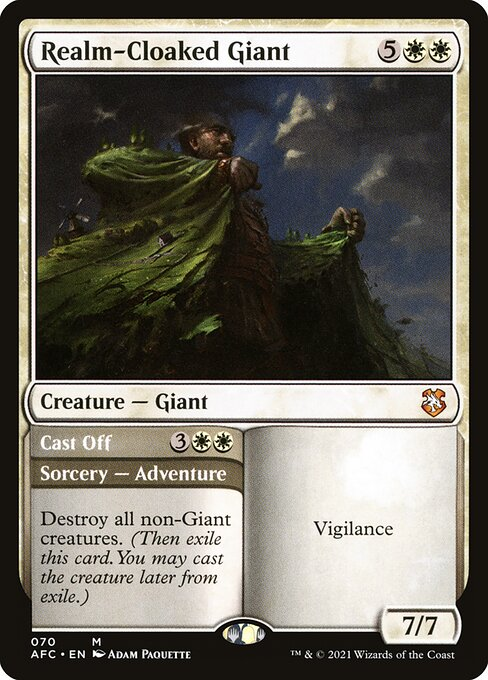

In [26]:
print(duplicate_card['name'])

# image uris have extra information at the end that is
# denoted by a ?, this needs to be stripped to be
# displayed properly 
Image(duplicate_card['image_uris'].iloc[0]['normal'].split('?')[0])

This is a card that has two names, generally these
cards are represented as "first name // second name" as
shown above (Realm-Cloaked Giant // Cast Off). Since
this card has two separate abilities that act as
different cards, it makes sense that this would have
more than one ID in some databases. We can safely
ignore this as long as the prices for both of the
halves are the same.  
But what about the entries that have _**FIVE**_ counts?

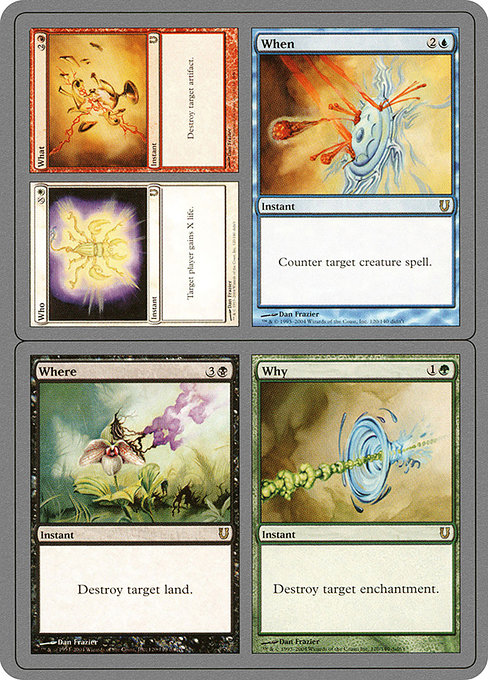

In [27]:
Image(all_cards[all_cards['id'] ==
    duplicates.sort_values('counts',ascending=False)['scryfall'].iloc[0]
    ]['image_uris'].iloc[0]['normal'].split('?')[0])

Ok, this is a joke card from one of Magic's "Un" sets.
This card isn't tournament-legal and also falls outside
of where we want to be looking anyway. We can go ahead
and reduce our main dataframe down to the cards we're
actually looking at and then reconfigure everything and
work on verifying the prices are all above board after.
This will prevent us from having to work on corner
cases that will take up a lot of time that isn't
strictly necessary.  
Let's go ahead and get rid of the meta information in
our all_prices dataframe first to make sure it isn't
forgotten.

In [28]:
all_prices = all_prices.drop(columns="meta").dropna()

We are going to look specifically at cards that are in
English, cards that are not oversized, cards that are
not tokens, emblems, schemes, or vanguards

In [29]:
print(all_cards.shape)
# only looking at english cards
all_cards = all_cards[all_cards['lang'] == 'en']
print(all_cards.shape)
# only want playable cards
all_cards = all_cards[all_cards['oversized'] == False]
print(all_cards.shape)
# determines frame, need to drop: token, emblem, scheme, vanguard
all_cards = all_cards[
    (~all_cards['layout'].isin(['token','emblem','scheme','vanguard']))
    ]
print(all_cards.shape)
# reduce this to only cards thate are printed on paper
all_cards = all_cards[all_cards['games'].map(
                lambda x: 'paper' in x
            )]
print(all_cards.shape)
# strip out gold and silver border cards from the set
all_cards = all_cards[(all_cards['border_color'] != 'silver') &
                    (all_cards['border_color'] != 'gold')]
print(all_cards.shape)
# every card has a type line, if that's missing - the
# entry is broken. 
all_cards = all_cards[~all_cards['type_line'].isna()]
print(all_cards.shape)

###########################

cleaned_cards = all_cards.drop(columns=[
    'lang','oversized','layout','games'
])

print(cleaned_cards.shape)
del all_cards
gc.collect()

(415580, 39)
(80033, 39)
(79470, 39)
(77435, 39)
(69414, 39)
(67533, 39)
(67520, 39)
(67520, 35)


0

Our full cards dataset dropped down from 415,580 to
69,414 entries. Most of that drop was just in narrowing
the targets to English cards, taking it down to only
20% of the data set.
Unfortunately, pricing data on non-english cards is
mostly inconsistent, especially on TCGPlayer, which is
the primary pricing dataset we'll be observing in this.

Now let's go back to the theory from before, that all
of the cards that have duplicate entries are cards that
have multiple items. We'll reduce duplicates down to
only the cards that exist in all_cards.

In [30]:
cleaned_cards['id']

0         0000579f-7b35-4ed3-b44c-db2a538066fe
1         00006596-1166-4a79-8443-ca9f82e6db4e
4         0000cd57-91fe-411f-b798-646e965eec37
6         00012bd8-ed68-4978-a22d-f450c8a6e048
17        0001f1ef-b957-4a55-b47f-14839cdbab6f
                          ...                 
415545    fff9989f-77a3-4f73-ade6-c04306c98501
415553    fffaa737-ce46-4f35-aa8c-bd9bb77ed9f6
415564    fffce2f7-b619-4483-a75e-916343194641
415568    fffe7b2b-22c3-4e6a-9b1b-c6d7b29b9f86
415572    ffff0825-9996-4ae5-90c8-cb976ccf4ae0
Name: id, Length: 67520, dtype: object

In [31]:
reduced_dupes = duplicates.merge(
    cleaned_cards['id'],
    left_on='scryfall',
    right_on='id',
    how='inner'
)
reduced_dupes.drop(columns='id',inplace=True)
reduced_dupes.isna().sum()

scryfall    0
uuid        0
name        0
set         0
counts      0
dtype: int64

In [32]:
scryfall_ids = reduced_dupes['scryfall'].unique()
unequal_cards = []
failed_cards  = []
for _sf_id in scryfall_ids:
    step='initializing scryfall id'
    _card_entry = reduced_dupes[reduced_dupes['scryfall'] == _sf_id]
    _check_ids = list(_card_entry['uuid'].values)
    try:
        _prices = {}
        _price_type = []
        step = f'pricing'
        for _id in _check_ids:
            _price_list = all_prices[
                all_prices.index == _id
            ]['data'].iloc[0]['paper']['tcgplayer']['retail']
            step=f"get price ... id: {_id}"
            _type = sorted(list(_price_list.keys()))[0]
            _price_type.append(_type)
            _prices[_id] = _price_list[_type]
        
        step = 'loading test'
        _price_test = [price for price in list(_prices.values())]
        step = 'check equal'
        is_equal = (sum(
            np.array(
                list(_price_test[0].values())
                ) - np.array(
                    list(_price_test[1].values()))
            )==0)
        if ~is_equal:
            step='unequal'
            for i, k in enumerate(_card_entry.index):
                unequal_cards.append(
                    {
                        'name':_card_entry.loc[k]['name'],
                        'uuid':_card_entry.loc[k]['uuid'],
                        'scryfall':_card_entry.loc[k]['scryfall'],
                        'prices':list(
                                _price_test[i].values()
                                ),
                        'price_type':_price_type[i]
                    }
                    )
    except:
        for i, k in enumerate(_card_entry.index):
                failed_cards.append(
                {
                    'name':_card_entry.loc[k]['name'],
                    'uuid':_card_entry.loc[k]['uuid'],
                    'scryfall':_card_entry.loc[k]['scryfall'],
                    'prices':list(
                            _price_test[i].values()
                            ),
                    'price_types':_price_type,
                    'failed_step':step
                }
        )
del reduced_dupes
del duplicates
del scryfall_ids
gc.collect()

0

In [33]:
# unequal_cards = pd.DataFrame(unequal_cards)
# unequal_cards[['name','prices']].iloc[:2]['prices']
# this was being used for testing and finding issues in
# the separation of values from the previous cell. 
# These issues have been corrected.
# unequal_cards[['name','prices','price_type']] 
unequal_cards

[]

In [34]:
failed_cards = pd.DataFrame(failed_cards)
failed_cards[['name','prices','price_types','failed_step']]

,name,prices,price_types,failed_step
0,Struggle // Survive,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
1,Struggle // Survive,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
2,"Invasion of Ikoria // Zilortha, Apex of Ikoria","[14.64, 14.33, 14.24, 14.16, 13.71, 13.24, 12....","[foil, foil]",check equal
3,"Invasion of Ikoria // Zilortha, Apex of Ikoria","[14.33, 14.24, 14.16, 13.71, 13.24, 12.69, 10....","[foil, foil]",check equal
4,Elesh Norn // The Argent Etchings,"[27.46, 25.38, 24.68, 23.35, 22.72, 21.73, 20....",[],pricing
5,Elesh Norn // The Argent Etchings,"[27.46, 25.38, 24.68, 23.35, 22.72, 21.73, 20....",[],pricing
6,Urabrask // The Great Work,[699.99],[],pricing
7,Urabrask // The Great Work,[699.99],[],pricing
8,Collectigull // Only the Best,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
9,Collectigull // Only the Best,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing


In [35]:
failed_cards

,name,uuid,scryfall,prices,price_types,failed_step
0,Struggle // Survive,4a1226c8-0f92-5da7-8c33-c09674688655,bf909dbb-6e49-4556-a37a-2738889915d1,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
1,Struggle // Survive,f46ac729-4ac8-5827-bb88-09a84542ebd0,bf909dbb-6e49-4556-a37a-2738889915d1,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
2,"Invasion of Ikoria // Zilortha, Apex of Ikoria",73bc51de-a0ad-5cde-a229-3ed3893c4764,5d59c8f2-f6af-40a6-8dfe-8cc45bf231ce,"[14.64, 14.33, 14.24, 14.16, 13.71, 13.24, 12....","[foil, foil]",check equal
3,"Invasion of Ikoria // Zilortha, Apex of Ikoria",1f8a8202-28ff-5337-ba0c-c06acec25162,5d59c8f2-f6af-40a6-8dfe-8cc45bf231ce,"[14.33, 14.24, 14.16, 13.71, 13.24, 12.69, 10....","[foil, foil]",check equal
4,Elesh Norn // The Argent Etchings,4e8747e2-642b-56e8-9ecb-71afb5b7af49,40307bcf-199c-4487-bfab-cb5fb841dee8,"[27.46, 25.38, 24.68, 23.35, 22.72, 21.73, 20....",[],pricing
5,Elesh Norn // The Argent Etchings,89cb157e-16dc-55d4-afd3-74efe0d3f70b,40307bcf-199c-4487-bfab-cb5fb841dee8,"[27.46, 25.38, 24.68, 23.35, 22.72, 21.73, 20....",[],pricing
6,Urabrask // The Great Work,7c8e0d52-0094-52c1-b92d-08342bf099bb,b12e031a-3a1a-4544-973b-e4e5b0518db9,[699.99],[],pricing
7,Urabrask // The Great Work,c6e5732c-f8f4-58c6-a67f-9021f2d0a7f0,b12e031a-3a1a-4544-973b-e4e5b0518db9,[699.99],[],pricing
8,Collectigull // Only the Best,f9788d9b-399c-5fc1-97ea-5149f4b8b741,5e5a037c-86b7-40f6-aa6e-74bc0b80e65e,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
9,Collectigull // Only the Best,66f18e7c-aa1f-5907-b549-875acbb688f4,5e5a037c-86b7-40f6-aa6e-74bc0b80e65e,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing


In [36]:
failed_prices = all_prices.merge(
    failed_cards,
    left_index=True,
    right_on='uuid',
    how='right'
)

In [37]:
checked_values = []
for i in range(0,len(failed_prices)):
    name = ''
    try:
        _foil = None
        _normal = None
        step='entering'
        failed_prices.iloc[i]
        step='locating'
        failed_prices.iloc[i]['name']
        step='name'
        name=failed_prices.iloc[i]['name']
        failed_prices.iloc[i]['data']
        step='data'
        failed_prices.iloc[i]['data']['paper']
        step='paper'
        failed_prices.iloc[i]['data']['paper']['tcgplayer']
        step='tcgplayer'
        failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']
        step='retail'
        try:
            failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']['normal']
            step='normal'
            _normal = True
        except:
            _normal = False
        try:
            failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']['foil']
            step='foil'
            _foil = True
        except:
            _foil = False
        step='complete'
    except:
        None
    checked_values.append({
        'step':step,
        'name': name,
        'foil':_foil,
        'normal':_normal
    })

In [38]:
pd.DataFrame(checked_values)

,step,name,foil,normal
0,tcgplayer,Struggle // Survive,None,None
1,tcgplayer,Struggle // Survive,None,None
2,complete,"Invasion of Ikoria // Zilortha, Apex of Ikoria",True,True
3,complete,"Invasion of Ikoria // Zilortha, Apex of Ikoria",True,True
4,tcgplayer,Elesh Norn // The Argent Etchings,None,None
5,tcgplayer,Elesh Norn // The Argent Etchings,None,None
6,tcgplayer,Urabrask // The Great Work,None,None
7,tcgplayer,Urabrask // The Great Work,None,None
8,tcgplayer,Collectigull // Only the Best,None,None
9,tcgplayer,Collectigull // Only the Best,None,None


In [39]:
del checked_values
gc.collect()

0

In [40]:
cleaned_cards

,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,oracle_text,...,rarity,border_color,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,14240.0,Fury Sliver,2006-10-06,{'small': 'https://cards.scryfall.io/small/fro...,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,...,uncommon,black,False,False,6038.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,33347.0,Kor Outfitter,2009-10-02,{'small': 'https://cards.scryfall.io/small/fro...,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",...,common,black,False,False,15041.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
4,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,145764.0,Siren Lookout,2017-09-29,{'small': 'https://cards.scryfall.io/small/fro...,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,...,common,black,False,False,13249.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
6,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,1623.0,Web,1994-04-01,{'small': 'https://cards.scryfall.io/small/fro...,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,...,rare,white,False,False,20164.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
17,0001f1ef-b957-4a55-b47f-14839cdbab6f,ef027846-be81-4959-a6b5-56bd01b1e68a,198861.0,Venerable Knight,2019-10-04,{'small': 'https://cards.scryfall.io/small/fro...,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",...,uncommon,black,False,False,13076.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415545,fff9989f-77a3-4f73-ade6-c04306c98501,e2fe1847-4003-41c5-a64b-03afd888b81e,52210.0,Morkrut Banshee,2011-09-30,{'small': 'https://cards.scryfall.io/small/fro...,{3}{B}{B},5.0,Creature — Spirit,Morbid — When Morkrut Banshee enters the battl...,...,uncommon,black,False,False,18176.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
415553,fffaa737-ce46-4f35-aa8c-bd9bb77ed9f6,de3ed52e-7cc2-49ea-96d9-4254aac46168,100411.0,Angel's Tomb,2015-07-17,{'small': 'https://cards.scryfall.io/small/fro...,{3},3.0,Artifact,Whenever a creature enters the battlefield und...,...,uncommon,black,False,False,17319.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
415564,fffce2f7-b619-4483-a75e-916343194641,6ecc61ff-719a-405d-b02a-01607729d05c,11217.0,Horned Troll,2003-07-28,{'small': 'https://cards.scryfall.io/small/fro...,{2}{G},3.0,Creature — Troll,{G}: Regenerate Horned Troll.,...,common,white,False,False,22226.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
415568,fffe7b2b-22c3-4e6a-9b1b-c6d7b29b9f86,d7ebd4a7-c542-469f-8a1c-d48b92fa540a,155714.0,Exultant Skymarcher,2018-01-19,{'small': 'https://cards.scryfall.io/small/fro...,{1}{W}{W},3.0,Creature — Vampire Soldier,Flying,...,common,black,False,False,18482.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN


In [41]:
display(all_prices.head(),
all_prices.shape)

,data
00010d56-fe38-5e35-8aed-518019aa36a5,{'paper': {'cardkingdom': {'buylist': {'foil':...
0001e0d0-2dcd-5640-aadc-a84765cf5fc9,{'paper': {'cardkingdom': {'buylist': {'normal...
0003caab-9ff5-5d1a-bc06-976dd0457f19,{'mtgo': {'cardhoarder': {'retail': {'foil': {...
0003d249-25d9-5223-af1e-1130f09622a7,{'mtgo': {'cardhoarder': {'retail': {'foil': {...
0004a4fb-92c6-59b2-bdbe-ceb584a9e401,{'mtgo': {'cardhoarder': {'retail': {'normal':...


(80093, 1)

In [42]:
display(id_mixer_df.head(),
id_mixer_df.shape)

,scryfall,uuid,name,set
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E


(80410, 4)

In [43]:
id_mixer_df.isna().sum().sum() , all_prices.isna().sum().sum()

(0, 0)

In [44]:
translated_prices = id_mixer_df.merge(
    all_prices,
    left_on='uuid',
    right_index=True,
    how='left'
)

In [45]:
translated_prices

,scryfall,uuid,name,set,data
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
...,...,...,...,...,...
80405,a3c2c3d7-3437-44b8-8d39-d3abe02af50e,3f492516-7767-5ed7-a1d4-e3f7c06aee2f,Into the Roil,ZNR,{'paper': {'tcgplayer': {'buylist': {'normal':...
80406,f7be5c0a-b538-4bc5-89c7-f5a81de7ccc3,3f9a0369-5fe7-5aee-85fe-3cfaacd275af,Bloodchief's Thirst,ZNR,{'paper': {'tcgplayer': {'buylist': {'normal':...
80407,560c02ec-f21e-405b-8267-7f7ff089904a,97577e9e-69a9-5a8b-9c24-a72703790046,Roil Eruption,ZNR,{'paper': {'cardmarket': {'retail': {'foil': {...
80408,5fa531b2-ccd5-489b-9edf-4cab01aca7fd,deb51cbd-b890-5b2d-9d6f-7b896e16c6fd,Roiling Regrowth,ZNR,{'paper': {'cardmarket': {'retail': {'normal':...


In [46]:
translated_prices.dropna(inplace=True)
translated_prices.drop_duplicates('scryfall',inplace=True)
translated_prices.shape

(74716, 5)

In [47]:
translated_prices.head()

,scryfall,uuid,name,set,data
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E,{'paper': {'cardkingdom': {'buylist': {'normal...


In [48]:
_listed_printings = []
for _card in translated_prices['data']:
    try:
        _listed_printings.extend(list(_card['paper']['tcgplayer']['retail'].keys()))
    except:
        continue
set(_listed_printings), len(_listed_printings)

({'foil', 'normal'}, 102392)

the only printings accounted for are 'foil' and
'normal' in this set.

In [49]:
flattened_prices = []
for i, _card in translated_prices.iterrows():
    _flat = {
        'prices_normal':None,
        'prices_foil':None
    }
    _flat['scryfall'] = _card['scryfall']
    try:
        _flat['prices_normal'] = _card['data']['paper']['tcgplayer']['retail']['normal']
    except:
        None
    try:
        _flat['prices_foil'] = _card['data']['paper']['tcgplayer']['retail']['foil']
    except:
        None
    flattened_prices.append(_flat)

flattened_prices = pd.DataFrame(flattened_prices)

In [50]:
cards_attached_prices = cleaned_cards.merge(
    flattened_prices,
    left_on='id',
    right_on='scryfall'
).drop(columns='scryfall')

print(f"""    Shapes:
cleaned_cards:          {cleaned_cards.shape}
flattened_prices:       {flattened_prices.shape}
cards_attached_prices:  {cards_attached_prices.shape}
""")

    Shapes:
cleaned_cards:          (67520, 35)
flattened_prices:       (74716, 3)
cards_attached_prices:  (65796, 37)



We lost a few entries but we still have tens of
thousands of entries, all tied to the primary data set,
and we likely only lost entries that we weren't worried
about anyway.

Time to clean up a bunch of variables and garbage
collect.

In [51]:
del flattened_prices, cleaned_cards, failed_cards,\
    failed_prices, id_mixer, id_mixer_df, \
    counted_mixer, trans_df, translated_prices, \
    used_columns, unequal_cards, duplicate_card, \
    all_prices
gc.collect()

0

In [52]:
cards_attached_prices.iloc[0]['name'], \
    dict(list(cards_attached_prices.iloc[0]['prices_normal'].items())[:5])

('Fury Sliver',
 {'2023-01-27': 0.37,
  '2023-01-28': 0.37,
  '2023-01-29': 0.37,
  '2023-01-31': 0.37,
  '2023-02-01': 0.37})

In [53]:
cards_attached_prices[
    (cards_attached_prices['prices_normal'].isna()) &
    (cards_attached_prices['prices_foil'].isna())
    ]['name']

36                     Mox Jet
153             Cyclopean Tomb
201               Disintegrate
272                      Taiga
410                  Meekstone
                 ...          
65386                 Blessing
65468              Wall of Air
65522    Stormscape Battlemage
65528            Shivan Dragon
65664          Underground Sea
Name: name, Length: 921, dtype: object

these look like they're primarily old, expensive cards
that tend not to sell frequently. There may be a few
things that are missed here.

In [54]:
cards_attached_prices = cards_attached_prices[
    (~cards_attached_prices['prices_normal'].isna()) |
    (~cards_attached_prices['prices_foil'].isna())
    ]
cards_attached_prices.shape

(64875, 37)

In [55]:
# fuller_vals

In [56]:
card_list = [
    # 'the tabernacle at pendrell vale',
    # 'kasmina, enigma sage',
    # 'steel overseer',
    # 'black lotus',
    # 'wrenn and six',
    # 'wrenn and seven',
    # 'liliana of the veil',
    'aluren'
]

In [57]:
card_sampler(cards_attached_prices,card_list=card_list)['image_uris'].iloc[0]

{'small': 'https://cards.scryfall.io/small/front/2/6/268403bc-733d-446e-a7c1-abc957c42bc2.jpg?1595430482',
 'normal': 'https://cards.scryfall.io/normal/front/2/6/268403bc-733d-446e-a7c1-abc957c42bc2.jpg?1595430482',
 'large': 'https://cards.scryfall.io/large/front/2/6/268403bc-733d-446e-a7c1-abc957c42bc2.jpg?1595430482',
 'png': 'https://cards.scryfall.io/png/front/2/6/268403bc-733d-446e-a7c1-abc957c42bc2.png?1595430482',
 'art_crop': 'https://cards.scryfall.io/art_crop/front/2/6/268403bc-733d-446e-a7c1-abc957c42bc2.jpg?1595430482',
 'border_crop': 'https://cards.scryfall.io/border_crop/front/2/6/268403bc-733d-446e-a7c1-abc957c42bc2.jpg?1595430482'}

In [58]:
Image?

Init signature:
Image(
    data=None,
    url=None,
    filename=None,
    format=None,
    embed=None,
    width=None,
    height=None,
    retina=False,
    unconfined=False,
    metadata=None,
    alt=None,
)
Docstring:      An object that wraps data to be displayed.
Init docstring:
Create a PNG/JPEG/GIF image object given raw data.

When this object is returned by an input cell or passed to the
display function, it will result in the image being displayed
in the frontend.

Parameters
----------
data : unicode, str or bytes
    The raw image data or a URL or filename to load the data from.
    This always results in embedded image data.

url : unicode
    A URL to download the data from. If you specify `url=`,
    the image data will not be embedded unless you also specify `embed=True`.

filename : unicode
    Path to a local file to load the data from.
    Images from a file are always embedded.

format : unicode
    The format of the image data (png/jpeg/jpg/gif). If a filename or

In [59]:
np.round(2.4+0.5)

3.0

In [60]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

In [61]:
import cv2

In [ ]:
vector_bytes_str = str(vector_bytes)
vector_bytes_str_enc = vector_bytes_str.encode()
bytes_np_dec = vector_bytes_str_enc.decode('unicode-escape').encode('ISO-8859-1')[2:-1]

In [113]:
imd_ = Image(image_uris[1]).data
try:
    strval = str(imd_)
    encval = strval.encode()

    rdc = encval.decode('unicode-escape')
    renc = rdc.encode('ISO-8859-1')
    np.frombuffer(renc[2:-1],dtype=np.float64)
except:
    np.frombuffer(imd_)

https://cards.scryfall.io/normal/front/d/3/d3bbaa00-71c3-4470-9576-cf724ae9d0fb.jpg


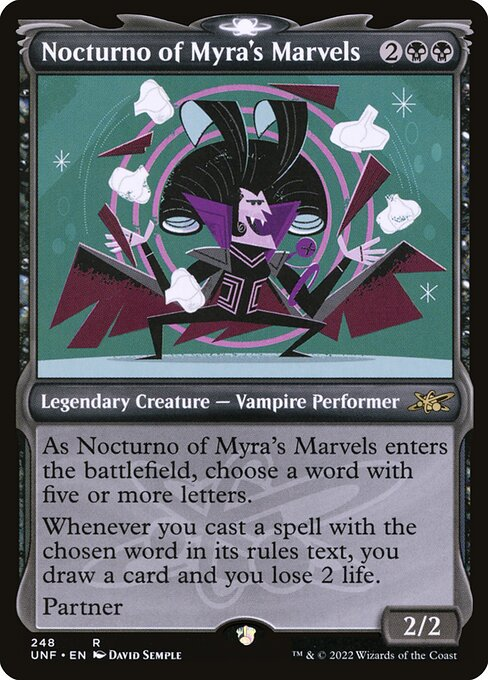

(-0.5, 487.5, 679.5, -0.5)

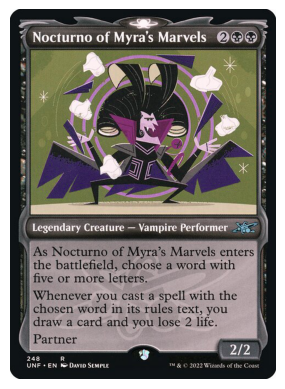

In [128]:
print(image_uris[0])
test_ = Image(image_uris[2])
display(test_)
type(test_)

str(test_).encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]

imarr = cv2.imdecode(np.frombuffer(test_.data,dtype='byte'),-1)

fig, ax = plt.subplots()
ax.imshow(imarr)
ax.imshow(imarr)
plt.axis('off')


In [131]:
testing_cards.iloc[-1]

index                                                         38764
id                             97502411-5c93-434c-b77b-ceb2c32feae7
oracle_id                      acfc3e07-757f-4ccf-a65e-bee07ce87f40
tcgplayer_id                                               229254.0
name                   Halvar, God of Battle // Sword of the Realms
released_at                                     2021-02-05 00:00:00
image_uris                                                      NaN
mana_cost                                                       NaN
cmc                                                             4.0
type_line         Legendary Creature — God // Legendary Artifact...
oracle_text                                                     NaN
power                                                           NaN
toughness                                                       NaN
colors                                                          NaN
color_identity                                  

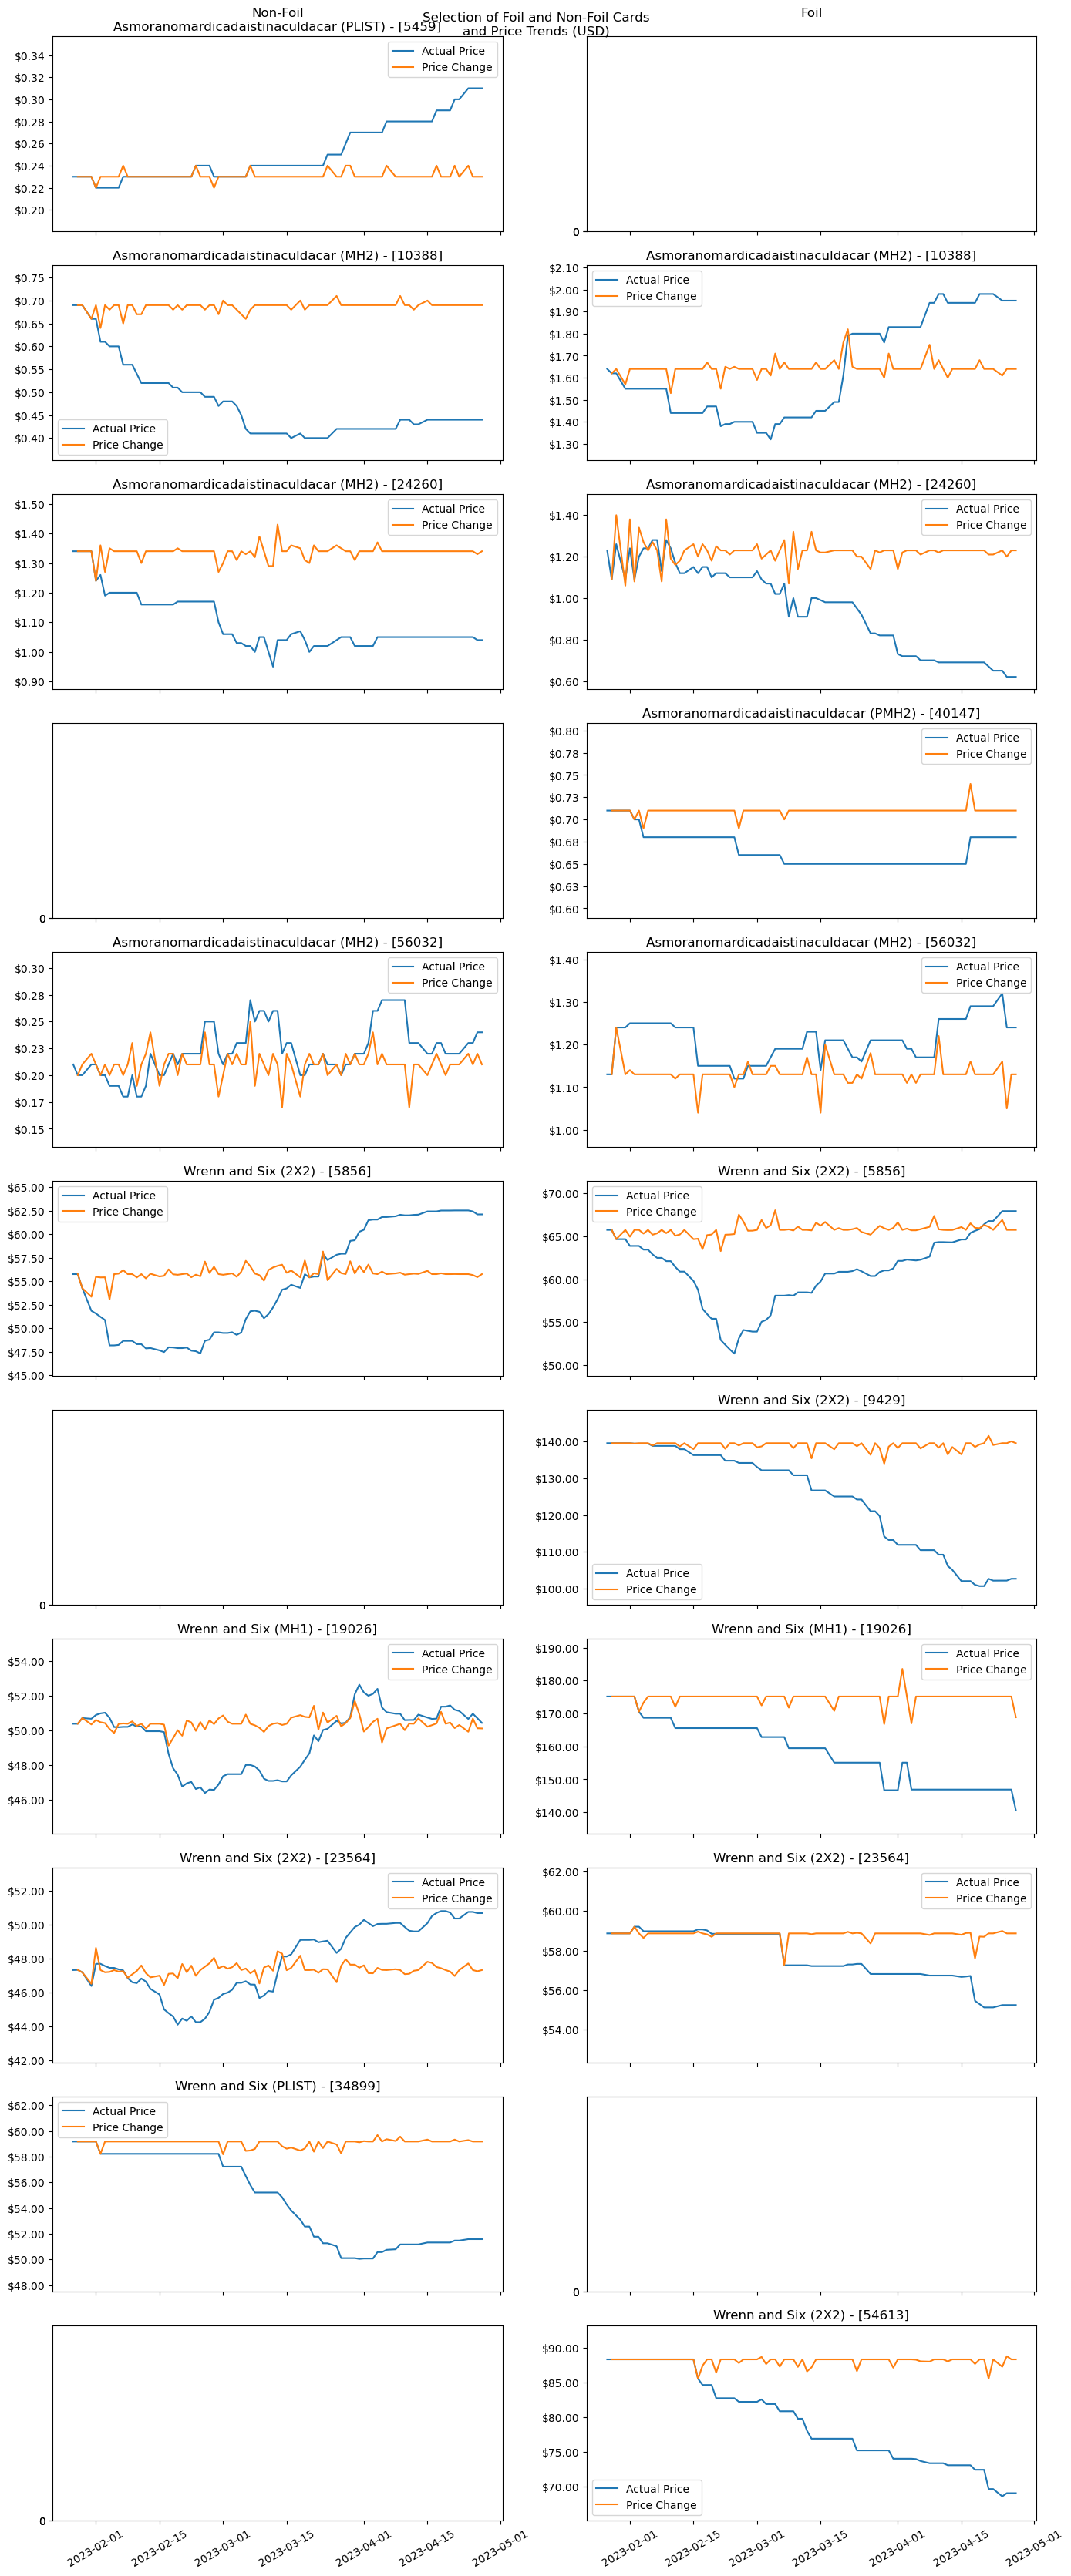

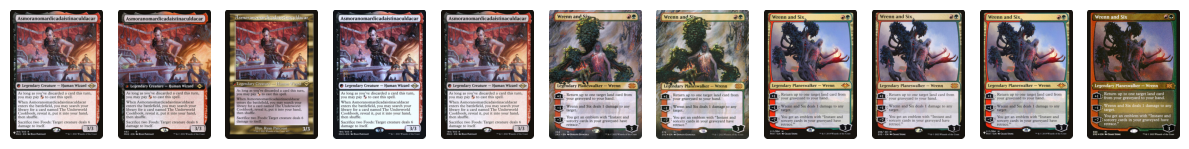

In [147]:
card_list = None
card_list = \
[
    # 'the tabernacle at pendrell vale',
    # 'kasmina, enigma sage',
    # 'steel overseer',
    # 'black lotus',
    'wrenn and six',
    # 'wrenn and seven',
    # 'liliana of the veil',
    'asmoranomardicadaistinaculdacar',
    # 'asmoranomardinacastinaculdicar'
]

n_cards = 4

leg_only = cards_attached_prices
[
(cards_attached_prices['type_line'].str.startswith('Legendary Creature')) &
(~cards_attached_prices['type_line'].isna())
]

testing_cards = card_sampler(
    # cards_attached_prices,
    leg_only,
    n_cards=n_cards,
    card_list=card_list
)

del leg_only
gc.collect()

plot_card_trends(
    testing_cards,
    card_list=card_list,
    # ax_scale=1.7,
    ax_scale=3,
    n_cards=n_cards
)

image_uris = card_imager(
    testing_cards,
    card_list=card_list,
    img_size='png',
    width=240,
    n_cards=n_cards,
    # hplot=False
)
'';

In [ ]:
cards_attached_prices['type_line'].isna().sum()

0

In [ ]:
testing_cards[testing_cards['type_line'].str.startswith('Legendary Creature')]

,index,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,...,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of,prices_normal,prices_foil
0,59012,e5483306-885c-44e1-84ce-b6e2124a6ecc,481fb71a-11b9-462e-a4da-ca35ffd1bd22,491854.0,"Squee, the Immortal",2023-04-21,{'small': 'https://cards.scryfall.io/small/fro...,{1}{R}{R},3.0,Legendary Creature — Goblin,...,False,False,1860.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-04-08': 0.8200000000000001, '2023-04-09...","{'2023-04-08': 2.45, '2023-04-09': 1.660000000..."
1,65474,feccd0e2-fae6-4ced-acdf-4252ed5c56e7,e55104e2-4900-48de-b288-d3e6abd5e09e,58185.0,"Sigarda, Host of Herons",2012-05-04,{'small': 'https://cards.scryfall.io/small/fro...,{2}{G}{W}{W},5.0,Legendary Creature — Angel,...,False,False,3376.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 6.87, '2023-01-28': 6.87, '2023...","{'2023-01-27': 30.95, '2023-01-28': 30.95, '20..."
2,2534,09ac9669-d0ee-4df8-af77-12dfccac774f,6969a7e2-6866-4001-a139-24b3be13deae,95315.0,"Alesha, Who Smiles at Death",2015-01-23,{'small': 'https://cards.scryfall.io/small/fro...,{2}{R},3.0,Legendary Creature — Human Warrior,...,False,False,2325.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.23, '2023-01-28': 0.23, '2023...","{'2023-01-27': 1.63, '2023-01-28': 1.63, '2023..."


In [ ]:
testing_cards

,index,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,...,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of,prices_normal,prices_foil
0,59012,e5483306-885c-44e1-84ce-b6e2124a6ecc,481fb71a-11b9-462e-a4da-ca35ffd1bd22,491854.0,"Squee, the Immortal",2023-04-21,{'small': 'https://cards.scryfall.io/small/fro...,{1}{R}{R},3.0,Legendary Creature — Goblin,...,False,False,1860.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-04-08': 0.8200000000000001, '2023-04-09...","{'2023-04-08': 2.45, '2023-04-09': 1.660000000..."
1,65474,feccd0e2-fae6-4ced-acdf-4252ed5c56e7,e55104e2-4900-48de-b288-d3e6abd5e09e,58185.0,"Sigarda, Host of Herons",2012-05-04,{'small': 'https://cards.scryfall.io/small/fro...,{2}{G}{W}{W},5.0,Legendary Creature — Angel,...,False,False,3376.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 6.87, '2023-01-28': 6.87, '2023...","{'2023-01-27': 30.95, '2023-01-28': 30.95, '20..."
2,2534,09ac9669-d0ee-4df8-af77-12dfccac774f,6969a7e2-6866-4001-a139-24b3be13deae,95315.0,"Alesha, Who Smiles at Death",2015-01-23,{'small': 'https://cards.scryfall.io/small/fro...,{2}{R},3.0,Legendary Creature — Human Warrior,...,False,False,2325.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.23, '2023-01-28': 0.23, '2023...","{'2023-01-27': 1.63, '2023-01-28': 1.63, '2023..."


In [ ]:
testing_cards['oracle_text'] = testing_cards.apply(synthesize_names,axis=1)
testing_cards[['oracle_text']]

,oracle_text
0,[You may cast CARDNAME from your graveyard or ...
1,"[Flying, hexproof, Spells and abilities your o..."
2,"[First strike, Whenever CARDNAME attacks, you ..."


In [ ]:
sample_ = testing_cards.iloc[1]
synthesized_names = []
for i, card in testing_cards.iterrows():
    synthesized_names.append(card['oracle_text'].replace(card['name'],'CARDNAME'))
synthesized_names

['You may cast CARDNAME from your graveyard or from exile.',
 "Flying, hexproof\nSpells and abilities your opponents control can't cause you to sacrifice permanents.",
 'First strike\nWhenever CARDNAME attacks, you may pay {W/B}{W/B}. If you do, return target creature card with power 2 or less from your graveyard to the battlefield tapped and attacking.']